In [29]:
import pandas as pd 
import glob
import json
import re

In [32]:
annotated_files = glob.glob('../app/data/output_data_affil-role/*/*')
checked_files = glob.glob('../app/data/checked_data_affil-role/*/*')

In [33]:
len(annotated_files)

221

In [5]:
all_annotated_data = []
all_input_docs = []
for fname in annotated_files:
    # see if we checked it 
    checked_name = fname.replace('output', 'checked').replace('annotated', 'checked')
    if checked_name in checked_files:
        fname = checked_name

    # 
    f_id = re.findall('\d+', fname.split('/')[-1])[0]
    with open(fname) as f:
        d = json.load(f)
        to_append = d['data']
        to_append['file_id'] = f_id
        all_annotated_data.append(to_append)
        
    inp_fname = fname.replace('_affil-role', '').replace('output', 'input').replace('annotated', 'to-annotate').replace('checked_', 'input_').replace('checked-', 'to-annotate-')
    with open(inp_fname) as f:
        inp = json.load(f)
    inp_doc = pd.DataFrame(inp['html_data'])[['sent_idx', 'sent']]
    inp_doc['sent'] = inp_doc['sent'].str.replace('<[^<]+?>', '', regex=True)
    inp_doc['file_id'] = 'doc_' + f_id
    all_input_docs.append(inp_doc)

In [6]:
all_data_df = pd.DataFrame(all_annotated_data)
all_input_doc_df = pd.concat(all_input_docs)

## data analysis

In [7]:
# likelihood of error given source type

In [8]:
all_doc_data = []
for idx, (data_row, error_dict, file_id) in all_data_df[['row_data', 'error_dict', 'file_id']].iterrows():
    error_row = pd.Series(error_dict)
    error_row.index = list(map(int, error_row.index))

    one_doc_data_df = pd.DataFrame(data_row).applymap(lambda x: x['field_value'] if isinstance(x, dict) else x)
    one_doc_data_df['error_type'] = error_row
    one_doc_data_df['doc_id'] = 'doc_' + file_id
    all_doc_data.append(one_doc_data_df)
    
all_doc_data_df = pd.concat(all_doc_data).reset_index(drop=True)

In [23]:
rename_sent_type = {
    'TWEET': 'SOCIAL MEDIA POST',
    'Other: Investigation': 'DATA ANALYSIS',
    'Other: Evaluation': '',
    'Other: PROPOSAL': 'PROPOSAL/ORDER/LAW',
    'Other: LAW': 'PROPOSAL/ORDER/LAW',
    'PROPOSAL': 'PROPOSAL/ORDER/LAW',
    'Other: Analysis': 'PUBLISHED WORK',
    'Other: Database': 'PUBLISHED WORK',
    'STOCK MARKET': 'PRICE SIGNAL'
}

In [24]:
remapped_quote_type_values = (all_doc_data_df['quote_type']
 .apply(lambda x: rename_sent_type.get(x, x))
 .str.replace('Other: ', '')
 .str.upper()
)

all_doc_data_df['quote_type'] = remapped_quote_type_values
all_doc_data_df['source_type'] = all_doc_data_df['source_type'].str.replace('Other: ', '')

In [29]:
doc_source_list = (
    all_doc_data_df
        .loc[lambda df: df['source_type'].isin(['Report/Document', 'Other: Vote/Poll', 'Database', 'Other: Database', 'Vote/Poll'])]
        ['head']
        .str.split('; ').apply(pd.Series)
        .unstack().dropna()
        .reset_index(drop=True)    
        .str.split('-').str.get(0)
        .str.lower()
        .str.strip()    
        .value_counts()
        .index.tolist()
)

anon_source_list = (
    all_doc_data_df
        .loc[lambda df: df['source_type'].isin(['Unnamed Group', 'Unnamed Individual'])]
        ['head']
        .str.lower()
        .str.split('; ').apply(pd.Series)
        .unstack().dropna()
        .reset_index(drop=True)                    
        .str.split('-').str.get(0)
        .str.lower()
        .str.strip()
        .value_counts()
        .index.tolist()
#  .pipe(lambda s: pd.Series(s.index).str.lower().unique())
)

import pyperclip

In [ ]:
def list_to_string(inp_list, split_lines_on_k=4):
    list_of_lists = []
    for i in range(split_lines_on_k):
        list_of_lists.append(inp_list[i::split_lines_on_k])
    # 
    pre_line_split_output = []
    rows = list(zip(*list_of_lists))
    # remainder
    remainder = inp_list[len(inp_list) - (len(inp_list) % split_lines_on_k):]
    rows.append(remainder)
    for l in rows:
        pre_line_split_output.append(', '.join(list(map(lambda x: '"%s"' % x.strip(), l))))
    return ',\n'.join(pre_line_split_output)    

In [31]:
pyperclip.copy(list_to_string(anon_source_list))

In [32]:
pyperclip.copy(list_to_string(doc_source_list))

In [33]:
anon_source_list

['officials',
 'experts',
 'authorities',
 'analysts',
 'scientists',
 'forecasters',
 'critics',
 'person',
 'democrats',
 'opponents',
 'police',
 'woman',
 'spokesman',
 'spokeswoman',
 'economists',
 'witnesses',
 'legal experts',
 'rights groups',
 'officers',
 'prosecutors',
 'pilot',
 'environmentalists',
 'administration officials',
 'people',
 'government scientists',
 'investigators',
 'neighbor',
 'plaintiffs',
 'environmental groups',
 'residents',
 'white house officials',
 'proponents',
 'environmental activists',
 'retailers',
 'iowa couple',
 'uber driver',
 'villagers',
 'volunteer',
 'a higher education trade group',
 'gun control groups',
 'gun rights advocates',
 'mining watchdog groups',
 'starbucks spokesman',
 'target spokeswoman',
 'gun control experts',
 'local media outlets',
 'israel',
 'provincial environmental officials',
 "marianne williamson's state director",
 'supporters',
 'local ’s boss',
 'researchers',
 'kathleen sgamma',
 'oil experts',
 'taciturn 

In [34]:
doc_source_list

['bill',
 'the washington post',
 'the associated press',
 'reuters',
 'poll',
 'report',
 'associated press',
 'polls',
 'study',
 'local media',
 'reports',
 'nbc news',
 'national poll',
 'article',
 'state television',
 'the cincinnati enquirer',
 'intergovernmental panel on climate change',
 'science',
 'stock market',
 'weekly newspaper',
 'white house fact sheet',
 'the sun',
 'united states federal aviation administration',
 'every list',
 'taizhou city environmental protection association',
 'news reports',
 'new york times investigation',
 'the chicago tribune',
 'chinese legislature',
 'prop . 22',
 'uber',
 'scientific studies',
 'california voters',
 'orlando sentinel',
 'law',
 'aaj tak television news channel',
 'pennsylvania poll',
 'the press trust of india news agency',
 'the gainesville sun',
 'china national radio',
 'sunderland',
 'cbs news',
 'lyft',
 'the national oceanic and atmospheric administration',
 'fivethirtyeight',
 'research',
 'washington post',
 'doss

In [35]:
unstacked_source_heads = (
    all_doc_data_df['head'].str.strip()
        .str.split(';', expand=True)
        .unstack()
        .dropna()
        .str.split('-').str.get(0)
        .reset_index(level=0, drop=True)
        .to_frame('head')
)

In [36]:
all_doc_data_df_source_unstacked = (
    all_doc_data_df
    .merge(unstacked_source_heads, left_index=True, right_index=True)
    .drop('head_x', axis=1)
    .rename(columns={'head_y': 'head'})
)

In [37]:
sources_and_bodies = (
    all_doc_data_df_source_unstacked[['row_idx', 'doc_id', 'head']]
         .merge(all_input_doc_df, left_on=['doc_id', 'row_idx'], right_on=['file_id', 'sent_idx'])
         .drop(['file_id', 'sent_idx'], axis=1)
         .groupby('doc_id')[['head', 'sent']]
         .aggregate(list)
         .assign(head=lambda df: 
                 df['head']
                     .apply(lambda x: list(set(filter(lambda y: y != '' and pd.notnull(y), x))))
    )
         .assign(sent=lambda df: df['sent'].str.join(' '))
)

source_in_body = (
    sources_and_bodies
         .apply(lambda x: list(map(lambda y: y.lower() in x['sent'].lower(), x['head'])), axis=1)
)

In [38]:
sources_and_bodies['source_in_body'] = source_in_body

In [346]:
(sources_and_bodies
 .apply(lambda x: list(filter(lambda y: not y[1], zip(x['head'], x['source_in_body']))), axis=1)
 .apply(lambda x: list(map(lambda y: y[0], x)))
 .apply(pd.Series)
 .unstack().dropna()
 .reset_index(level=0, drop=True)
)

doc_id
doc_123                    government officials
doc_149                             Jerry Brown
doc_166                           Billl Bunting
doc_186                      Bernstein analysts
doc_204    Marianne Williamson's state director
doc_221                        Mr. Biden's team
doc_230                    Brazilian government
doc_372                 native american leaders
doc_395                       defendents lawyer
doc_399                Julián Castro's campaign
doc_446                               opponents
doc_519                                 unnamed
doc_556                   Ms. Taylor ’s lawyers
doc_564                         bill's sponsors
doc_592                   Asia Development Bank
doc_621                            Barack Obama
doc_74                            mine's owners
doc_81                    Australian government
doc_842                     CNBC's "Squawk Box"
doc_864      The Mauritian environment ministry
doc_867                          

In [42]:
(
    sources_and_bodies
     .apply(lambda x: list(filter(lambda y: not y[1], zip(x['head'], x['source_in_body']))), axis=1)
     .apply(lambda x: list(map(lambda y: y[0], x)))
     .loc[lambda s: s.apply(lambda x: x != [])]
)

doc_id
doc_123                               [government officials]
doc_147            [Dalai Lama's Secretary,   Penpa Tsering]
doc_149                                        [Jerry Brown]
doc_166                                      [Billl Bunting]
doc_186                                 [Bernstein analysts]
doc_204    [iowa couple, Marianne Williamson's state dire...
doc_221                    [Julian Castro, Mr. Biden's team]
doc_230                               [Brazilian government]
doc_312        [colleague of Reid Hoffman, Election experts]
doc_372                [native american leaders, protestors]
doc_386                                [Facebook spokewoman]
doc_395                                  [defendents lawyer]
doc_399                           [Julián Castro's campaign]
doc_435                              [Exxon Mobile, reports]
doc_446                              [opponents, proponents]
doc_519                               [another man, unnamed]
doc_520          

In [16]:
training_data_df = pd.merge(
    left=all_doc_data_df,
    right=all_input_doc_df,
    left_on=['doc_id', 'row_idx'],
    right_on=['file_id', 'sent_idx']
)

In [173]:
(training_data_df
 .assign(source=lambda df: df['quote_type'] != '')
 [['source', 'sent', 'file_id', 'head', 'sent_idx', 'quote_type', 'tagline', 'source_type', 'affiliation', 'role', 'role_status']]
 .rename(columns={'source': 'label', 'sent':'sentence', 'file_id': 'entry_id'})
#  .to_csv('../models_neural/quote_detection/data/our-annotated-data-full.tsv', sep='\t', index=False)
#  .to_csv('../models_neural/quote_detection/data/our-annotated-data-full.csv.gz', compression='gzip', index=False)
 .to_csv('../data/our-annotated-data-full.csv.gz', compression='gzip', index=False)
)

In [33]:
training_data_df.to_csv('../data/annotated-source-training-df.csv')

In [121]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(training_data_df['doc_id'].drop_duplicates().tolist())

In [129]:
split_df = pd.concat([
    pd.Series(train_ids).to_frame('file_id').assign(split_type='/train/'),
    pd.Series(test_ids).to_frame('file_id').assign(split_type='/test/')
])

In [146]:
(
    training_data_df
     .merge(split_df, left_on='file_id', right_on='file_id')
     .assign(source=lambda df: df['quote_type'] != '')
     .assign(file_id=lambda df: df['split_type'] + df['file_id'])
     .rename(columns={'sent':'s', 'file_id': 't_id'})
     [['source', 's', 't_id', 'sent_idx']]
     .to_csv('../data/our-annotated-source-training-df.tsv', index=False, sep='\t')
)

In [47]:
num_sents_per_source = (
    all_doc_data_df
        .assign(c=1)
        .loc[lambda df: df['head'] != '']
        .groupby(['doc_id', 'head'])['c']
        .sum()
        .to_frame('num_sents_per_source')
)
num_sents_per_doc = all_doc_data_df['doc_id'].value_counts().to_frame('num_sents_per_doc')

all_doc_data_df = (
    all_doc_data_df
        .merge(num_sents_per_source.reset_index(), left_on=['doc_id', 'head'], right_on=['doc_id', 'head'], how='left')
        .merge(num_sents_per_doc, left_on='doc_id', right_index=True, how='left')
)

In [48]:
all_doc_data_df['error_type'].value_counts()

no_errors                               5109
false_negative_source_caught             689
false_negative_source_uncaught           464
false_negative_wrong_source_existing     230
wrong_sentence_role                      165
false_negative_wrong_source_new          100
false_positive_sentence                   78
Name: error_type, dtype: int64

In [49]:
all_doc_data_df[[
    'row_idx', 'head', 'quote_type', 'tagline', 'source_type', 'affiliation', 'role', 'role_status'
]]=all_doc_data_df[[
    'row_idx', 'head', 'quote_type', 'tagline', 'source_type', 'affiliation', 'role', 'role_status'
]].fillna('')

# Analyze Aggregate Source Information

In [50]:
sentence_features = (
    all_doc_data_df
         .loc[lambda df: df['head'] != '']
         .groupby(['doc_id', 'head'])
         [['quote_type', 'error_type']]
         .aggregate(list)
)

In [51]:
source_features = (all_doc_data_df
     .loc[lambda df: df['head'] != '']
     .loc[lambda df: df['source_type'] != '']
)

duplicates = (source_features
     .set_index(['doc_id', 'head'])
     .pipe(lambda df: 
          df.loc[
              df.assign(c=1).groupby(level=[0,1])['c'].sum().loc[lambda s: s > 1].index 
          ]
    )
)

# doc_id, s_idx, row_idx
to_drop = [('doc_311', 3, 25), ('doc_510', 2, 0), ('doc_182', 4, 35), ('doc_149', 10, 76)]

source_features = (source_features
 .reset_index()
 .assign(s_idx=lambda df: df['s_idx'].fillna(20).astype(int))
 .sort_values(['doc_id', 's_idx'])
)

source_features = (
    source_features
    .loc[lambda df: ~df.apply(lambda x: (x['doc_id'], x['s_idx'], x['row_idx']), axis=1).isin(to_drop)]
    .drop(['quote_type', # 'row_idx', #'s_idx',
           'error_type'], axis=1)
    .set_index(['doc_id', 'head'])
)

# source_data_df = pd.concat([source_features, sentence_features], axis=1)

In [52]:
source_features.reset_index()['head'].isnull().value_counts()

False    967
Name: head, dtype: int64

In [53]:
source_features.reset_index().assign(c=1).groupby(['doc_id', 'head'])['c'].sum().value_counts()

1    967
Name: c, dtype: int64

In [54]:
sentence_features

quote_type  \
doc_id  head                                                                        
doc_0    Norwegian Cruise Line                                        [STATEMENT]   
        Andrew M. Cuomo                            [PUBLIC SPEECH, NOT TO JOURNO]   
        Hertz                                                         [STATEMENT]   
        Nicholas Calio          [COMMUNICATION, NOT TO JOURNO, COMMUNICATION, ...   
        developers                                                 [QUOTE, QUOTE]   
...                                                                           ...   
doc_956 Chicago police                                             [QUOTE, QUOTE]   
        Gabriela Ramirez                             [QUOTE, QUOTE, QUOTE, QUOTE]   
        John Hagedorn                                                     [QUOTE]   
        Marcos Ceniceros        [QUOTE, QUOTE, QUOTE, QUOTE, QUOTE, QUOTE, QUO...   
        The Chicago Tribune                                      [PUBLISHED WORK]   

                                                                       error_type  
doc_id  head                                                                       
doc_0    Norwegian Cruise Line                   [false_negative_source_uncaught]  
        Andrew M. Cuomo                          [false_negative_source_uncaught]  
        Hertz                                    [false_negative_source_uncaught]  
        Nicholas Calio          [false_negative_source_caught, no_errors, wron...  
        developers              [false_negative_source_uncaught, false_negativ...  
...                                                                           ...  
doc_956 Chicago police          [false_negative_source_uncaught, false_negativ...  
        Gabriela Ramirez             [no_errors, no_errors, no_errors, no_errors]  
        John Hagedorn                                                 [no_errors]  
        Marcos Ceniceros        [false_negative_source_caught, false_negative_...  
        The Chicago Tribune                      [false_negative_source_uncaught]  

[967 rows x 2 columns]

In [55]:
source_data_df = pd.concat([source_features, sentence_features], axis=1)

In [56]:
source_data_df.loc['doc_912']

,index,row_idx,tagline,source_type,affiliation,role,role_status,s_idx,num_sents_per_source,num_sents_per_doc,quote_type,error_type
head,,,,,,,,,,,,
Dennis Feltgen,192,26,a spokesman and meteorologist with the center...,Named Individual,Government,Representative,Current,1,3.0,30,"[QUOTE, QUOTE, QUOTE]","[no_errors, no_errors, no_errors]"
Phil Klotzbach,176,10,a research scientist in the department of atmo...,Named Individual,Academic,Decision Maker,Current,0,3.0,30,"[QUOTE, QUOTE, QUOTE]","[no_errors, no_errors, no_errors]"
scientists,189,23,government scientists,Unnamed Group,Government,Informational,Current,2,1.0,30,[QUOTE],[false_negative_source_uncaught]


In [57]:
source_data_df['source_type'].value_counts()

Named Individual      555
Unnamed Group         149
Named Group           127
Report/Document        83
Unnamed Individual     42
Vote/Poll               5
Other: Vote/Poll        3
Database                2
Other: Database         1
Name: source_type, dtype: int64

In [58]:
# source_data_df.loc[lambda df: df['source_type'] == 'Unnamed Group'].reset_index()['head'].values

In [59]:
(source_data_df
 .groupby('affiliation')['source_type']
 .value_counts()
 .unstack()
 .fillna(0).astype(int)
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0).round(3)*100)
)

source_type,Database,Named Group,Named Individual,Other: Database,Other: Vote/Poll,Report/Document,Unnamed Group,Unnamed Individual,Vote/Poll
affiliation,,,,,,,,,
Academic,0.0,3.7,66.7,0.0,0.0,3.7,24.7,1.2,0.0
Actor,1.2,1.2,68.8,0.0,1.2,1.2,16.2,10.0,0.0
Cannot Determine,0.0,0.0,0.0,0.0,0.0,9.1,81.8,9.1,0.0
Corporate,0.0,24.3,51.5,0.0,0.0,2.9,15.5,5.8,0.0
Government,0.3,17.3,55.3,0.3,0.0,8.1,15.0,3.7,0.0
Industry Group,0.0,15.4,46.2,0.0,0.0,0.0,30.8,7.7,0.0
Media,0.0,11.7,18.2,0.0,0.0,55.8,10.4,2.6,1.3
NGO,0.0,15.9,71.4,0.0,0.0,3.2,9.5,0.0,0.0
Other Group,0.0,20.0,60.0,0.0,0.0,13.3,6.7,0.0,0.0


In [60]:
uncaught_errors = set(['false_negative_source_uncaught', 'false_negative_wrong_source_new'])

In [61]:
source_data_df['uncaught'] = source_data_df['error_type'].apply(lambda x: len(set(x) & uncaught_errors) > 0)

In [62]:
error_by_source_type = (
    source_data_df
     .groupby('source_type')['uncaught']
     .value_counts()
     .unstack()
     .fillna(0).astype(int)
     .pipe(lambda df: df.divide(df.sum(axis=1), axis=0).round(3)*100)
)

In [63]:
import pyperclip

In [64]:
pyperclip.copy(error_by_source_type[False].to_latex())

In [65]:
# source_data_df.loc[lambda df: df['source_type'] == 'Unnamed Group'].loc[lambda df: df['uncaught'] == False]
# source_data_df.loc[lambda df: df['source_type'] == 'Named Group'].loc[lambda df: df['uncaught'] == False]

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
error_distribution_per_caught_source = (
    source_data_df
        .loc[lambda df: df['uncaught'] == False]
        ['error_type'].apply(lambda x: pd.Series(x).value_counts())
        .fillna(0)
        .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [68]:
(    source_data_df
        .loc[lambda df: df['uncaught'] == False]
        ['error_type'].apply(lambda x: pd.Series(x).value_counts())
        .fillna(0).pipe(lambda df: df > 0)
         .mean()
)

wrong_sentence_role                     0.166253
false_negative_source_caught            0.290323
no_errors                               0.980149
false_negative_wrong_source_existing    0.094293
dtype: float64

In [69]:
error_distribution_per_caught_source.mean()

wrong_sentence_role                     0.055670
false_negative_source_caught            0.086910
no_errors                               0.825996
false_negative_wrong_source_existing    0.031425
dtype: float64

# Test other methods

In [47]:
import sys
sys.path.insert(0, '../scripts/')
import util
from spacy.language import Language
import spacy
nlp = spacy.load('en_core_web_lg')
import numpy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, SENT_START
from spacy.tokens import Doc

@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    to_pop = []
    for token in doc[:-1]:
        if token.text == "SENT_BOUNDARY":
            doc[token.i + 1].is_sent_start = True
            to_pop.append(token.i)
        else:
            doc[token.i + 1].is_sent_start = False
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA, SENT_START])
    np_array = numpy.delete(np_array, to_pop, axis=0)
    doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in to_pop])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA, SENT_START], np_array)
    return doc2

nlp.add_pipe("set_custom_boundaries", before="parser")

from jellyfish import jaro_similarity

def ent_dicts_to_row_idxs(ent_dict):
    output_sents = []
    for name, sentence_dict in ent_dict.items():
        for sent_type in ['quote sentence', 'background sentence']:
            for sent_idx, sent in sentence_dict[sent_type]:
                output_sents.append({
                    'sent_idx': sent_idx,
                    'head': name,
                    'sent_type': sent_type
                })
    return sorted(output_sents, key=lambda x: x['sent_idx'])

def check_row_false_pos_neg(row):
    if (row['pred_head'] == '') and (row['head'] == ''):
        return 'no_error'

    pred_head = util.remove_problematic_name_parts(row['pred_head'])
    head = util.remove_problematic_name_parts(row['head'])
    
    pred_head_parts, head_parts = pred_head.strip().split(), head.strip().split()
    if len(head_parts) > 0:
        last_name_head = head_parts[-1]
    else:
        last_name_head = ''
        
    if len(pred_head_parts) > 0:
        last_name_pred_head = pred_head_parts[-1]
    else:
        last_name_pred_head = ''
    
    if jaro_similarity(last_name_pred_head, last_name_head) > .9:
        return 'no_error'
    elif (pred_head != '') and (head != ''):
        return 'wrong_source'
    elif pred_head == '':
        return 'false_negative'
    elif head == '':
        return 'false_positive'

def check_wrong_type(row):
    pred_sent_type = row['pred_sent_type']
    pred_sent_type = pred_to_label_mapper.get(pred_sent_type, pred_sent_type)
    return pred_sent_type != row['quote_type']

pred_to_label_mapper = {
    'quote sentence': 'QUOTE',
    'background sentence': 'BACKGROUND',
}

def get_sent_labels_old_methods(method_func, input_df, annotated_df):
    # put together document
    s = ' SENT_BOUNDARY '.join(input_df['sent'].tolist())
    s = re.sub('<[^<]+?>', '', s)
    doc = nlp(s)

    # label/score 
    unclustered = method_func(doc)
    name_c = util.cluster_by_name_overlap_jaro(unclustered)
    cluster_mapper, _, _, _ = util.get_name_cluster_head_by_length(name_c)
    clustered_entities = util.merge_clusters(unclustered, cluster_mapper)

    # put together in DF
    to_check = ent_dicts_to_row_idxs(clustered_entities)
    to_check_df = (pd.DataFrame(to_check)
        .rename(columns={'head': 'pred_head', 'sent_type': 'pred_sent_type', 'sent_idx': 'row_idx'})
        .merge(one_doc_annotated_df, left_on='row_idx', right_on='row_idx', how='right')
        .fillna('')
    )
    return to_check_df


def calculate_metrics(to_check_df):
    to_check_df['false_pos_neg'] = to_check_df.apply(check_row_false_pos_neg, axis=1)
    to_check_df['wrong_sent_type'] = to_check_df.apply(check_wrong_type, axis=1)

    true_aggregated = (
        to_check_df
         .groupby('head')['false_pos_neg']
         .aggregate(list)
         .loc[lambda s: s.index != '']
    )

    pred_aggregated = (
        to_check_df
         .groupby('pred_head')['false_pos_neg']
         .aggregate(list)
         .loc[lambda s: s.index != '']
    )
    
    metrics_dict = {}
    uncaught = true_aggregated.apply(lambda x: all(map(lambda y: (y == 'false_negative') or (y == 'wrong_source'), x)))
    invented = pred_aggregated.apply(lambda x: all(map(lambda y: (y == 'false_positive') or (y == 'wrong_source'), x)))
    
    acc = true_aggregated.apply(lambda x: any(map(lambda y: y == 'no_error', x)))
    source_type = (
        to_check_df
        .loc[lambda df: df['source_type'] != '']
        .groupby('head')['source_type']
        .aggregate(list)
        .apply(lambda x: list(set(x))[0])
    )
    
    metrics_dict['no_errors'] = acc.sum()
    metrics_dict['num_uncaught'] = uncaught.sum()
    metrics_dict['num_invented'] = invented.sum()
    metrics_dict['num_real_sources'] = len(to_check_df['head'].loc[lambda s: s != ''].drop_duplicates())
    metrics_dict['num_found_sources'] = len(to_check_df['pred_head'].loc[lambda s: s != ''].drop_duplicates())
    
    metrics_dict['precision'] = metrics_dict['no_errors'] / metrics_dict['num_found_sources']
    metrics_dict['recall'] = metrics_dict['no_errors'] / metrics_dict['num_real_sources']
    
    metrics_dict['f1_score'] = 2 * metrics_dict['precision'] * metrics_dict['recall'] / (metrics_dict['precision'] + metrics_dict['recall'])
    
    metrics_dict['% missed by source'] = (
        true_aggregated
            .loc[~uncaught]
            .apply(lambda x: (len(x) - sum(map(lambda y: y == 'no_error', x))) / len(x))
            .to_dict()
    )

    metrics_dict['% invented by source'] = (
        pred_aggregated
            .loc[~invented]
            .apply(lambda x: (len(x) - sum(map(lambda y: y == 'no_error', x))) / len(x))
            .to_dict()
    )

    metrics_dict['% wrong sent type by source'] = (to_check_df
         .loc[lambda df: df['false_pos_neg'] == 'no_error']
         .groupby('head')['wrong_sent_type']
         .aggregate(list).loc[lambda s: s.index != '']
         .loc[~uncaught]
         .apply(lambda x: sum(x)/len(x))
         .to_dict()
    )
    
    metrics_dict['acc. by source type'] = pd.concat([source_type, acc], axis=1).to_dict()
    
    return metrics_dict

### metrics to track:

* \# of totally invented sources
* \# of totally uncaught sources
* for sources that are found
    * % of uncaught lines per source
    * % of overcaught lines per source
    * % of wrong-type lines

In [48]:
glob.glob('../app/data/output_data_affil-role/*/*')[:3]

['../app/data/output_data_affil-role/18/annotated-902.json',
 '../app/data/output_data_affil-role/18/annotated-934.json',
 '../app/data/output_data_affil-role/18/annotated-919.json']

In [49]:
from tqdm import tqdm
from importlib import reload

In [50]:
reload(util)

<module 'util' from '../scripts/util.py'>

In [51]:
orig_ner = True
orig_speaking = False

method_1 = lambda doc: util.get_quotes_method_1(
    doc,
    orig_speaking=orig_speaking,
    orig_ner=orig_ner
)

method_2 = lambda doc: util.get_quotes_method_2(
    doc=doc, 
    cluster=False,
    dedupe_sents=False,
    resolve_coref=False,
    greedyness=.4,
    max_dist=150,
    orig_ner=orig_ner,
    orig_speaking=orig_speaking
)

In [62]:
test_docs = ["doc_11", "doc_12", "doc_123", "doc_14", "doc_15", "doc_166", "doc_18", "doc_230", "doc_279", "doc_320", "doc_327", "doc_375", "doc_383", "doc_393", "doc_4", "doc_407", "doc_490", "doc_499", "doc_510", "doc_514", "doc_519", "doc_628", "doc_643", "doc_652", "doc_661", "doc_715", "doc_722", "doc_74", "doc_798", "doc_80", "doc_862", "doc_905", "doc_912", "doc_93", "doc_937"]
test_docs = list(map(lambda x: re.search('\d+', x)[0], test_docs))

In [67]:
docs_to_calculate_metrics_over = glob.glob('../app/data/output_data_affil-role/*/*')
docs_to_calculate_metrics_over = list(filter(lambda x: re.search('\d+', x.split('/')[-1])[0] in test_docs, docs_to_calculate_metrics_over))

In [68]:
all_method_1_to_check, all_method_2_to_check, all_method_3_to_check = [], [], []
all_metrics_method_1, all_metrics_method_2, all_metrics_method_3 = [], [], []
for fname in tqdm(docs_to_calculate_metrics_over):
    checked_name = fname.replace('output', 'checked').replace('annotated', 'checked')
    if checked_name in checked_files:
        fname = checked_name

    input_fname = (
        fname
            .replace('checked_', 'input_').replace('output_', 'input_')
            .replace('_affil-role', '')
            .replace('checked', 'to-annotate').replace('annotated', 'to-annotate')
    )

    with open(fname) as f:
        annotated_data = json.load(f)
        
    with open(input_fname) as f:
        input_data = json.load(f)

    one_doc_annotated_df = (
        pd.DataFrame(annotated_data['data']['row_data'])
         .applymap(lambda x: x['field_value'] if isinstance(x, dict) else x)
         [['row_idx', 'head', 'quote_type', 'source_type']].fillna('')
    )

    one_doc_input_df = pd.DataFrame(input_data['html_data'])[['sent_idx', 'sent']]
    
    to_check_df = get_sent_labels_old_methods(method_2, one_doc_input_df, one_doc_annotated_df)
    metrics_dict = calculate_metrics(to_check_df)
    all_metrics_method_2.append(metrics_dict)
    all_method_2_to_check.append(to_check_df)
    
    to_check_df = get_sent_labels_old_methods(method_1, one_doc_input_df, one_doc_annotated_df)
    to_check_df = to_check_df.merge(one_doc_input_df, left_on='row_idx', right_on='sent_idx')
    all_method_1_to_check.append(to_check_df)
    
    metrics_dict = calculate_metrics(to_check_df)
    all_metrics_method_1.append(metrics_dict)
    
    
    method_3_pred_df = (
        pd.DataFrame(input_data['html_data'])[['type', 'head']]
            .fillna('')
            .rename(columns={'head': 'pred_head', 'type':'pred_sent_type'})
    )

    method_3_df_to_check = pd.concat([one_doc_annotated_df, method_3_pred_df], axis=1)
    all_method_3_to_check.append(method_3_df_to_check)
    method_3_metrics_dict = calculate_metrics(method_3_df_to_check)
    all_metrics_method_3.append(method_3_metrics_dict)

  0%|          | 0/35 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


In [69]:
all_method_1_to_check_df = pd.concat(all_method_1_to_check)
all_method_2_to_check_df = pd.concat(all_method_2_to_check)
all_method_3_to_check_df = pd.concat(all_method_3_to_check)

In [70]:
from sklearn.metrics import f1_score

In [71]:
(all_method_1_to_check_df[['pred_sent_type', 'quote_type']]
 .pipe(lambda df: df != '')
 .pipe(lambda df: f1_score(df['quote_type'], df['pred_sent_type']))
)

0.7837514934289127

In [72]:
(all_method_2_to_check_df[['pred_sent_type', 'quote_type']]
 .pipe(lambda df: df != '')
 .pipe(lambda df: f1_score(df['quote_type'], df['pred_sent_type']))
)

0.5437017994858613

In [73]:
(all_method_3_to_check_df[['pred_sent_type', 'quote_type']]
 .pipe(lambda df: df != '')
 .pipe(lambda df: f1_score(df['quote_type'], df['pred_sent_type']))
)

0.7704714640198511

In [74]:
method_1_metrics_df = pd.DataFrame(all_metrics_method_1)
method_2_metrics_df = pd.DataFrame(all_metrics_method_2)
method_3_metrics_df = pd.DataFrame(all_metrics_method_3)
method_1_metrics_df['% missed'] = method_1_metrics_df['% missed by source'].apply(lambda x: pd.Series(x).mean())
method_2_metrics_df['% missed'] = method_2_metrics_df['% missed by source'].apply(lambda x: pd.Series(x).mean())
method_3_metrics_df['% missed'] = method_3_metrics_df['% missed by source'].apply(lambda x: pd.Series(x).mean())
method_1_metrics_df['% invented'] = method_1_metrics_df['% invented by source'].apply(lambda x: pd.Series(x).mean())
method_2_metrics_df['% invented'] = method_2_metrics_df['% invented by source'].apply(lambda x: pd.Series(x).mean())
method_3_metrics_df['% invented'] = method_3_metrics_df['% invented by source'].apply(lambda x: pd.Series(x).mean())

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explici

In [75]:
overall_metric_df = pd.concat([
    method_1_metrics_df.mean().to_frame('Method 1'),
    method_2_metrics_df.mean().to_frame('Method 2'),
    method_3_metrics_df.mean().to_frame('Method 3')
], axis=1).T.round(2)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.pa

In [76]:
overall_metric_df.drop(['% missed', '% invented'], axis=1)

,no_errors,num_uncaught,num_invented,num_real_sources,num_found_sources,precision,recall,f1_score
Method 1,4.69,1.60,12.00,6.29,16.46,0.27,0.79,0.39
Method 2,3.60,2.69,3.37,6.29,6.91,0.55,0.63,0.58
Method 3,2.77,3.51,0.17,6.29,2.91,0.93,0.52,0.64


In [77]:
overall_metric_df.drop(['% missed', '% invented'], axis=1)

,no_errors,num_uncaught,num_invented,num_real_sources,num_found_sources,precision,recall,f1_score
Method 1,4.69,1.60,12.00,6.29,16.46,0.27,0.79,0.39
Method 2,3.60,2.69,3.37,6.29,6.91,0.55,0.63,0.58
Method 3,2.77,3.51,0.17,6.29,2.91,0.93,0.52,0.64


In [78]:
overall_metric_df.drop(['% missed', '% invented'], axis=1)

,no_errors,num_uncaught,num_invented,num_real_sources,num_found_sources,precision,recall,f1_score
Method 1,4.69,1.60,12.00,6.29,16.46,0.27,0.79,0.39
Method 2,3.60,2.69,3.37,6.29,6.91,0.55,0.63,0.58
Method 3,2.77,3.51,0.17,6.29,2.91,0.93,0.52,0.64


In [79]:
print(overall_metric_df.drop(['% missed', '% invented'], axis=1).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  no\_errors &  num\_uncaught &  num\_invented &  num\_real\_sources &  num\_found\_sources &  precision &  recall &  f1\_score \\
\midrule
Method 1 &       4.69 &          1.60 &         12.00 &              6.29 &              16.46 &       0.27 &    0.79 &      0.39 \\
Method 2 &       3.60 &          2.69 &          3.37 &              6.29 &               6.91 &       0.55 &    0.63 &      0.58 \\
Method 3 &       2.77 &          3.51 &          0.17 &              6.29 &               2.91 &       0.93 &    0.52 &      0.64 \\
\bottomrule
\end{tabular}



In [80]:
print(overall_metric_df[['% missed', '% invented']].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  \% missed &  \% invented \\
\midrule
Method 1 &      0.75 &        0.13 \\
Method 2 &      0.50 &        0.09 \\
Method 3 &      0.15 &        0.08 \\
\bottomrule
\end{tabular}



In [81]:
metrics_by_source_type = pd.concat([

(df['acc. by source type']
 .apply(pd.DataFrame).pipe(lambda df: pd.concat(df.tolist()))
 .groupby('source_type')['false_pos_neg'].mean().to_frame('Method %s' % (i+1))
)

    for i, df in enumerate([method_1_metrics_df, method_2_metrics_df, method_3_metrics_df])
], axis=1).sort_values('Method 3',ascending=False).round(3) * 100

In [86]:
metrics_by_source_type.rename(columns=lambda x: 'Rules ' + re.search('\d', x)[0])

,Rules 1,Rules 2,Rules 3
source_type,,,
Named Individual,94.4,94.4,77.4
Named Group,3.4,10.3,3.4
Report/Document,40.0,20.0,0.0
Unnamed Group,80.6,2.8,0.0
Unnamed Individual,71.4,0.0,0.0
Vote/Poll,100.0,25.0,0.0


In [89]:
metrics_by_source_type.index.tolist()

['Named Individual',
 'Named Group',
 'Report/Document',
 'Unnamed Group',
 'Unnamed Individual',
 'Vote/Poll']

In [765]:
metrics_by_source_type

,Method 1,Method 2,Method 3
source_type,,,
Named Individual,94.6,94.6,79.8
Named Group,0.0,3.0,1.5
Other: Vote/Poll,33.3,33.3,0.0
Report/Document,0.0,13.8,0.0
Unnamed Group,0.0,1.4,0.0
Unnamed Individual,5.9,5.9,0.0


In [766]:
pyperclip.copy(metrics_by_source_type.to_latex())

# Code for Robin's Class

In [773]:
## source type

pyperclip.copy(source_data_df['source_type'].value_counts().to_latex())

In [808]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

In [815]:
ls ../latex/robins-class/

project-final/  project-update/


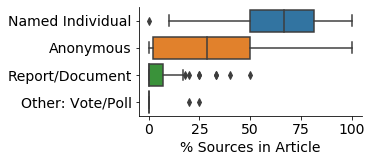

In [820]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
anon_cols = ['Unnamed Group', 'Named Group', 'Unnamed Individual']
(source_data_df
 .assign(c=1)
 .reset_index()
 .groupby(['doc_id', 'source_type'])['c']
 .sum().unstack().fillna(0)
 .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
 .assign(Anonymous=lambda df: df[anon_cols].sum(axis=1))
 .drop(anon_cols, axis=1)
#  .sum(axis=1)
 .unstack()
 .reset_index()
 .pipe(lambda df: sns.boxplot(data=df.assign(p=lambda df: df[0]*100).sort_values('p', ascending=False), y='source_type', x='p', ax=ax))
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
# plt.xticks(rotation=45)
ax.set_xlabel('% Sources in Article')
plt.savefig('../latex/robins-class/project-final/figures/source-usage-by-source-type-boxplot.png', bbox_inches='tight')

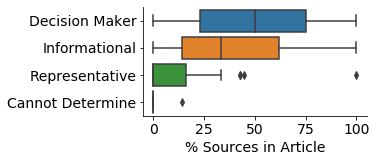

In [829]:
dm_cols = ['Decision Maker', 'Participant']
f, ax = plt.subplots(1, 1, figsize=(4, 2))
(source_data_df
 .assign(c=1)
 .reset_index()
 .groupby(['doc_id', 'role'])['c']
 .sum().unstack().fillna(0)
 .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
 .assign(**{'Decision Maker': lambda df: df[dm_cols].sum(axis=1)})
 .drop('Participant', axis=1)
#  .sum(axis=1)
 .unstack()
 .reset_index()
 .pipe(lambda df: sns.boxplot(data=df.assign(p=lambda df: df[0]*100).sort_values('p', ascending=False), y='role', x='p', ax=ax))
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
# plt.xticks(rotation=45)
ax.set_xlabel('% Sources in Article')
plt.savefig('../latex/robins-class/project-final/figures/source-usage-by-role-boxplot.png', bbox_inches='tight')

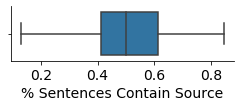

In [839]:
f, ax = plt.subplots(1, 1, figsize=(4, 1))

(all_doc_data_df
 .assign(is_source_sent=lambda df: df['head'] != '')
 .groupby('doc_id')['is_source_sent']
 .mean()
 .pipe(lambda s: sns.boxplot(s))
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
# plt.xticks(rotation=45)
ax.set_xlabel('% Sentences Contain Source')
plt.savefig('../latex/robins-class/project-final/figures/source-usage-by-sentence-boxplot.png', bbox_inches='tight')

In [854]:
source_data_df.reset_index()['doc_id'].value_counts().quantile(.25)

4.0

In [777]:
source_data_df

index  row_idx  \
doc_id  head                                     
doc_0    Norwegian Cruise Line    982       24   
        Andrew M. Cuomo           980       22   
        Hertz                     983       25   
        Nicholas Calio            985       27   
        developers                994       36   
...                               ...      ...   
doc_956 Chicago police           2562       28   
        Gabriela Ramirez         2585       51   
        John Hagedorn            2577       43   
        Marcos Ceniceros         2555       21   
        The Chicago Tribune      2546       12   

                                                                          tagline  \
doc_id  head                                                                        
doc_0    Norwegian Cruise Line                                                 na   
        Andrew M. Cuomo                                      Governor of New York   
        Hertz                                                                  na   
        Nicholas Calio                     Airlines for America's chief executive   
        developers                                                             na   
...                                                                           ...   
doc_956 Chicago police                                                         na   
        Gabriela Ramirez                                                       33   
        John Hagedorn           a criminologist at the University of Illinois ...   
        Marcos Ceniceros        an organizer with the Brighton Park Neighborho...   
        The Chicago Tribune                                                    na   

                                     source_type affiliation            role  \
doc_id  head                                                                   
doc_0    Norwegian Cruise Line       Named Group   Corporate  Decision Maker   
        Andrew M. Cuomo         Named Individual  Government  Decision Maker   
        Hertz                        Named Group   Corporate  Decision Maker   
        Nicholas Calio          Named Individual   Corporate     Participant   
        developers                 Unnamed Group       Actor  Decision Maker   
...                                          ...         ...             ...   
doc_956 Chicago police               Named Group  Government   Informational   
        Gabriela Ramirez        Named Individual     Witness     Participant   
        John Hagedorn           Named Individual    Academic   Informational   
        Marcos Ceniceros        Named Individual       Actor     Participant   
        The Chicago Tribune      Report/Document       Media   Informational   

                               role_status  s_idx  num_sents_per_source  \
doc_id  head                                                              
doc_0    Norwegian Cruise Line     Current      2                   1.0   
        Andrew M. Cuomo            Current      1                   1.0   
        Hertz                      Current      3                   1.0   
        Nicholas Calio             Current      0                   6.0   
        developers                 Current      4                   2.0   
...                                    ...    ...                   ...   
doc_956 Chicago police             Current      6                   2.0   
        Gabriela Ramirez           Current      4                   4.0   
        John Hagedorn              Current      3                   1.0   
        Marcos Ceniceros           Current      1                   9.0   
        The Chicago Tribune        Current      5                   1.0   

                                num_sents_per_doc  \
doc_id  head                                        
doc_0    Norwegian Cruise Line                 44   
        Andrew M. Cuomo                        44   
        Hertz                                 

In [767]:
(source_data_df
 .loc[lambda df: df['uncaught'] == True]
 ['quote_type'].apply(lambda x: pd.Series(x).value_counts())
 .fillna(0)
 .sum()
)

STATEMENT                        48.0
PUBLIC SPEECH, NOT TO JOURNO     10.0
QUOTE                           282.0
COMMUNICATION, NOT TO JOURNO     13.0
BACKGROUND                       39.0
PRESS REPORT                     32.0
PUBLISHED WORK                   54.0
TWEET                            22.0
DOCUMENT                         25.0
DECLINED COMMENT                  9.0
Other: Investigation              1.0
Other: VOTE/POLL                  6.0
PROPOSAL                          1.0
Other: LAW                        1.0
dtype: float64

# Old Analysis showing our tool was broken

In [16]:
annotated_files[0]

'../app/data/output_data_affil-role/18/annotated-919.json'

In [57]:
with open('../app/data/input_data/18/to-annotate-919.json') as f:
    input_data = json.load(f)

In [59]:
with open(annotated_files[0]) as f:
    output_data = json.load(f)

In [60]:
output_data

{'data': [{'s_idx': 12,
   'head': None,
   'quote_type': None,
   'tagline': None,
   'source_type': {'field_value': 'Named Individual',
    'knowledge_source': None},
   'affiliation': {'field_value': 'Government', 'knowledge_source': None},
   'role': {'field_value': 'Decision Maker', 'knowledge_source': None},
   'role_status': {'field_value': 'Former', 'knowledge_source': None}},
  {'s_idx': 18,
   'head': None,
   'quote_type': None,
   'tagline': None,
   'source_type': {'field_value': 'Named Individual',
    'knowledge_source': None},
   'affiliation': {'field_value': 'Industry Group', 'knowledge_source': None},
   'role': {'field_value': 'Representative', 'knowledge_source': None},
   'role_status': {'field_value': 'Current', 'knowledge_source': None}},
  {'s_idx': 29,
   'head': None,
   'quote_type': None,
   'tagline': None,
   'source_type': {'field_value': 'Named Individual',
    'knowledge_source': None},
   'affiliation': {'field_value': 'Government', 'knowledge_source'

In [10]:
output_files = glob.glob('../app/data/output_data_affil-role/*/*')
files_df = pd.Series(output_files).to_frame('filename')

In [11]:
import os

In [12]:
files_df= (files_df
 .assign(time=lambda df: df['filename'].apply(os.path.getmtime))
 .sort_values('time', ascending=False)
)

In [15]:
all_data = []
for fname in output_files:
    with open(fname) as f:
        s = json.load(f)
        all_data.append(s)

In [16]:
pd.DataFrame(all_data).sort_values('end_time', ascending=False).iloc[0]['data']

{'row_data': [{'row_idx': 0,
   'head': {'field_value': '', 'knowledge_source': None},
   'quote_type': {'field_value': '', 'knowledge_source': None},
   'tagline': {'field_value': '', 'knowledge_source': None},
   'source_type': {'field_value': '', 'knowledge_source': None},
   'affiliation': {'field_value': '', 'knowledge_source': None},
   'role': {'field_value': '', 'knowledge_source': None},
   'role_status': {'field_value': '', 'knowledge_source': None}},
  {'row_idx': 1,
   'head': {'field_value': '', 'knowledge_source': None},
   'quote_type': {'field_value': '', 'knowledge_source': None},
   'tagline': {'field_value': '', 'knowledge_source': None},
   'source_type': {'field_value': '', 'knowledge_source': None},
   'affiliation': {'field_value': '', 'knowledge_source': None},
   'role': {'field_value': '', 'knowledge_source': None},
   'role_status': {'field_value': '', 'knowledge_source': None}},
  {'row_idx': 2,
   'head': {'field_value': '', 'knowledge_source': None},
   'q

In [17]:
pd.DataFrame(all_data).iloc[0]['data']

{'row_data': [{'row_idx': 0,
   'head': {'field_value': '', 'knowledge_source': None},
   'quote_type': {'field_value': '', 'knowledge_source': None},
   'tagline': {'field_value': '', 'knowledge_source': None},
   'source_type': {'field_value': '', 'knowledge_source': None},
   'affiliation': {'field_value': '', 'knowledge_source': None},
   'role': {'field_value': '', 'knowledge_source': None},
   'role_status': {'field_value': '', 'knowledge_source': None}},
  {'row_idx': 1,
   'head': {'field_value': '', 'knowledge_source': None},
   'quote_type': {'field_value': '', 'knowledge_source': None},
   'tagline': {'field_value': '', 'knowledge_source': None},
   'source_type': {'field_value': '', 'knowledge_source': None},
   'affiliation': {'field_value': '', 'knowledge_source': None},
   'role': {'field_value': '', 'knowledge_source': None},
   'role_status': {'field_value': '', 'knowledge_source': None}},
  {'row_idx': 2,
   's_idx': 1,
   'head': {'field_value': 'Laotian diplomats', 

In [248]:
output_data['data']

[{'s_idx': 12,
  'head': None,
  'quote_type': None,
  'tagline': None,
  'source_type': {'field_value': 'Named Individual', 'knowledge_source': None},
  'affiliation': {'field_value': 'Government', 'knowledge_source': None},
  'role': {'field_value': 'Decision Maker', 'knowledge_source': None},
  'role_status': {'field_value': 'Former', 'knowledge_source': None}},
 {'s_idx': 18,
  'head': None,
  'quote_type': None,
  'tagline': None,
  'source_type': {'field_value': 'Named Individual', 'knowledge_source': None},
  'affiliation': {'field_value': 'Industry Group', 'knowledge_source': None},
  'role': {'field_value': 'Representative', 'knowledge_source': None},
  'role_status': {'field_value': 'Current', 'knowledge_source': None}},
 {'s_idx': 29,
  'head': None,
  'quote_type': None,
  'tagline': None,
  'source_type': {'field_value': 'Named Individual', 'knowledge_source': None},
  'affiliation': {'field_value': 'Government', 'knowledge_source': None},
  'role': {'field_value': 'Decisi

In [118]:
input_rows = input_data['html_data']

In [119]:
output_rows = output_data['data']

In [126]:
list(output_rows[0].keys())

['s_idx',
 'head',
 'quote_type',
 'tagline',
 'source_type',
 'affiliation',
 'role',
 'role_status']

In [165]:
import re
task = 'affil-role'
to_check = glob.glob('../app/data/output_data_%s/*/*' % task)
to_check = list(map(lambda x: (x, re.findall('annotated-\d+', x)[0]), to_check))
to_check = sorted(map(lambda x: (x[0], x[1].replace('annotated', 'checked')), to_check))

checked = glob.glob('../app/data/checked_data_%s/*/*' % task)
checked_files = set(map(lambda x: re.findall('checked-\d+', x)[0], checked))

to_check = list(filter(lambda x: x[1] not in checked_files, to_check))

In [166]:
to_check[0]

('../app/data/output_data_affil-role/0/annotated-0.json', 'checked-0')

In [174]:
fname

'../app/data/output_data_affil-role/0/annotated-0.json'

In [167]:
fname, file_id = to_check[0]
output_fn = fname.replace('output_data', 'checked_data')
output_dir = os.path.dirname(output_fn)
output_fn = os.path.join(output_dir, file_id + '.json')

In [168]:
output_fn

'../app/data/checked_data_affil-role/0/checked-0.json'

In [170]:
with open(fname) as f:
    t = json.load(f)

In [171]:
t

{'data': [{'s_idx': 27,
   'head': None,
   'quote_type': None,
   'tagline': None,
   'affiliation': {'field_value': 'Corporate', 'knowledge_source': None},
   'role': {'field_value': 'Participant', 'knowledge_source': None},
   'role_status': {'field_value': 'Current', 'knowledge_source': None}}],
 'start_time': '1651796639.453419',
 'output_fname': '../app/data/output_data_affil-role/0/annotated-0.json',
 'end_time': 1651796789.913613}

In [186]:
ls ../app/data/checked_data_affil-role/0

checked-0.json   checked-10.json  checked-12.json  checked-14.json
checked-1.json   checked-11.json  checked-13.json


In [187]:
fname = '../app/data/checked_data_affil-role/0/checked-14.json'
with open(fname) as f:
    checked = json.load(f)

In [192]:
pd.DataFrame(checked['data']['row_data']).loc[lambda df: df['s_idx'].notnull()]

,row_idx,head,quote_type,tagline,source_type,affiliation,role,role_status,s_idx
1,1,"{'field_value': 'Jeff Tan', 'knowledge_source'...","{'field_value': 'BACKGROUND', 'knowledge_sourc...","{'field_value': 'na', 'knowledge_source': None}","{'field_value': 'Named Individual', 'knowledge...","{'field_value': 'Academic', 'knowledge_source'...","{'field_value': 'Participant', 'knowledge_sour...","{'field_value': 'Former', 'knowledge_source': ...",0
2,2,"{'field_value': 'Jeff Tan', 'knowledge_source'...","{'field_value': 'BACKGROUND', 'knowledge_sourc...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",0
6,6,"{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",0
8,8,"{'field_value': 'Jeff Tan', 'knowledge_source'...","{'field_value': 'QUOTE', 'knowledge_source': N...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",0
9,9,"{'field_value': 'Jeff Tan', 'knowledge_source'...","{'field_value': 'QUOTE', 'knowledge_source': N...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",0
10,10,"{'field_value': 'Jeff Tan', 'knowledge_source'...","{'field_value': 'QUOTE', 'knowledge_source': N...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",0
13,13,"{'field_value': 'draft', 'knowledge_source': N...","{'field_value': 'DOCUMENT', 'knowledge_source'...",{'field_value': 'draft of a proposed executive...,"{'field_value': 'Report/Document', 'knowledge_...","{'field_value': 'Government', 'knowledge_sourc...","{'field_value': 'Decision Maker', 'knowledge_s...","{'field_value': 'Current', 'knowledge_source':...",7
14,14,"{'field_value': 'draft', 'knowledge_source': N...","{'field_value': 'DOCUMENT', 'knowledge_source'...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",7
16,16,"{'field_value': 'critics', 'knowledge_source':...","{'field_value': 'QUOTE', 'knowledge_source': N...","{'field_value': 'H-1B program ’s critics', 'kn...","{'field_value': 'Unnamed Group', 'knowledge_so...","{'field_value': 'Cannot Determine', 'knowledge...","{'field_value': 'Cannot Determine', 'knowledge...","{'field_value': 'Cannot Determine', 'knowledge...",8
17,17,"{'field_value': 'critics', 'knowledge_source':...","{'field_value': 'QUOTE', 'knowledge_source': N...","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}","{'field_value': '', 'knowledge_source': None}",8


In [193]:
checked

{'data': {'row_data': [{'row_idx': 0,
    'head': {'field_value': '', 'knowledge_source': None},
    'quote_type': {'field_value': '', 'knowledge_source': None},
    'tagline': {'field_value': '', 'knowledge_source': None},
    'source_type': {'field_value': '', 'knowledge_source': None},
    'affiliation': {'field_value': '', 'knowledge_source': None},
    'role': {'field_value': '', 'knowledge_source': None},
    'role_status': {'field_value': '', 'knowledge_source': None}},
   {'row_idx': 1,
    's_idx': '0',
    'head': {'field_value': 'Jeff Tan', 'knowledge_source': None},
    'quote_type': {'field_value': 'BACKGROUND', 'knowledge_source': None},
    'tagline': {'field_value': 'na', 'knowledge_source': None},
    'source_type': {'field_value': 'Named Individual',
     'knowledge_source': None},
    'affiliation': {'field_value': 'Academic', 'knowledge_source': None},
    'role': {'field_value': 'Participant', 'knowledge_source': None},
    'role_status': {'field_value': 'Former', 

In [1053]:
t = fname.replace('_affil-role', '').replace('output', 'input').replace('annotated', 'to-annotate')

import datetime

with open(t) as f:
    inp = json.load(f)

pd.merge(
    left=pd.DataFrame(inp['html_data']),
    right=pd.DataFrame(d['data']['row_data']),
    left_on='sent_idx',
    right_on='row_idx'
).loc[12]['sent']

datetime.datetime.fromtimestamp(d['end_time'])

FileNotFoundError: [Errno 2] No such file or directory: '../app/data/checked_data/14/checked-730.json'

In [81]:
import datetime

In [103]:
datetime.datetime.fromtimestamp(1652092713.237974)

datetime.datetime(2022, 5, 9, 3, 38, 33, 237974)

In [ ]:
from tqdm.auto import tqdm

import spacy

ner_list = [
    'CARDINAL',
    'DATE',
    'EVENT',
    'FAC',
    'GPE',
    'LANGUAGE',
    'LAW',
    'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']

list(map(lambda x: (x, spacy.explain(x)), ner_list))

'NORP',
'PERSON',
'ORG',
'GPE',
'LAW',